In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.05, .3, .35, .3, 1], index=['CLZ9', 'ESZ9', 'GCZ9', 'NQZ9', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-02-12')
del df['sys_time']
del df['reports']
del df['exec_ids']
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2019-02-21 03:55:00,NQZ9,BUY,3,7088.525,1,entry,6.30,0.00,100000.00
2019-02-21 07:37:00,ESZ9,BUY,3,2791.775,3,entry,6.30,0.00,100000.00
2019-02-21 13:33:00,GCZ9,BUY,3,1339.000,5,entry,7.26,0.00,100000.00
2019-02-21 15:07:00,GCZ9,SELL,3,1336.570,6,stop-out,7.26,-257.52,99742.48
2019-02-21 15:35:00,NQZ9,SELL,3,7048.300,7,close,6.30,-817.10,98925.38
...,...,...,...,...,...,...,...,...,...
2019-10-30 19:01:00,GCZ9,SELL,3,1493.050,2318,entry,7.26,0.00,98352.83
2019-10-30 19:53:00,NQZ9,BUY,2,8075.250,2320,entry,4.20,0.00,98352.83
2019-10-30 19:57:00,ESZ9,BUY,2,3040.150,2322,entry,4.20,0.00,98352.83


In [4]:
df.groupby('contract').realizedPNL.sum()

contract
CLZ9   -3209.07
ESZ9   -5351.74
GCZ9    2887.44
NQZ9    4176.68
Name: realizedPNL, dtype: float64

In [5]:
df.realizedPNL.sum()

-1496.6900000000023

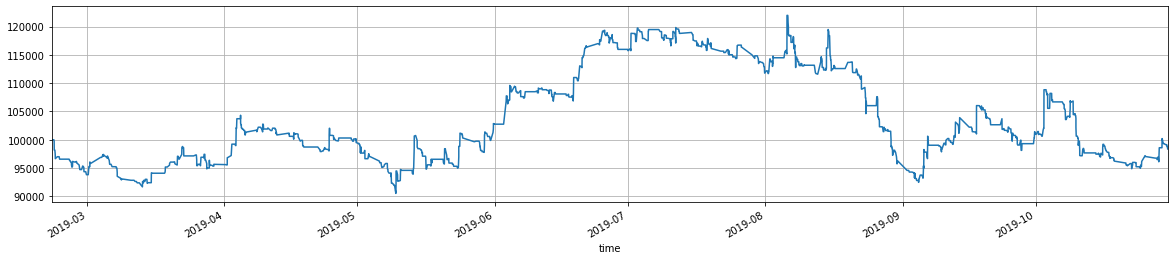

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CLZ9    168
ESZ9    285
GCZ9    983
NQZ9    289
Name: action, dtype: int64

In [9]:
# commission paid
df.groupby('contract').commission.sum()

contract
CLZ9     398.16
ESZ9    1701.00
GCZ9    8114.26
NQZ9    1541.40
Name: commission, dtype: float64

In [10]:
df.commission.sum()

11754.820000000002

In [11]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GCZ9,0.31,5.88,574.81,-254.11,2.26,2.86,491.0
NQZ9,0.38,29.00,1204.68,-697.54,1.73,25.30,144.0
ESZ9,0.37,-37.69,886.18,-587.86,1.51,-42.47,142.0
CLZ9,0.27,-38.20,1445.43,-597.61,2.42,-45.99,84.0


In [12]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CLZ9', 'ESZ9', 'GCZ9', 'NQZ9']].plot(figsize=(20,8), grid=True);

In [13]:
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

contract,CLZ9,ESZ9,GCZ9,NQZ9,total
contract,,,,,
CLZ9,1.000000,-0.015652,0.058498,-0.116016,0.299953
ESZ9,-0.015652,1.000000,-0.017087,0.565810,0.724182
GCZ9,0.058498,-0.017087,1.000000,-0.114799,0.351019
NQZ9,-0.116016,0.565810,-0.114799,1.000000,0.734851
total,0.299953,0.724182,0.351019,0.734851,1.000000


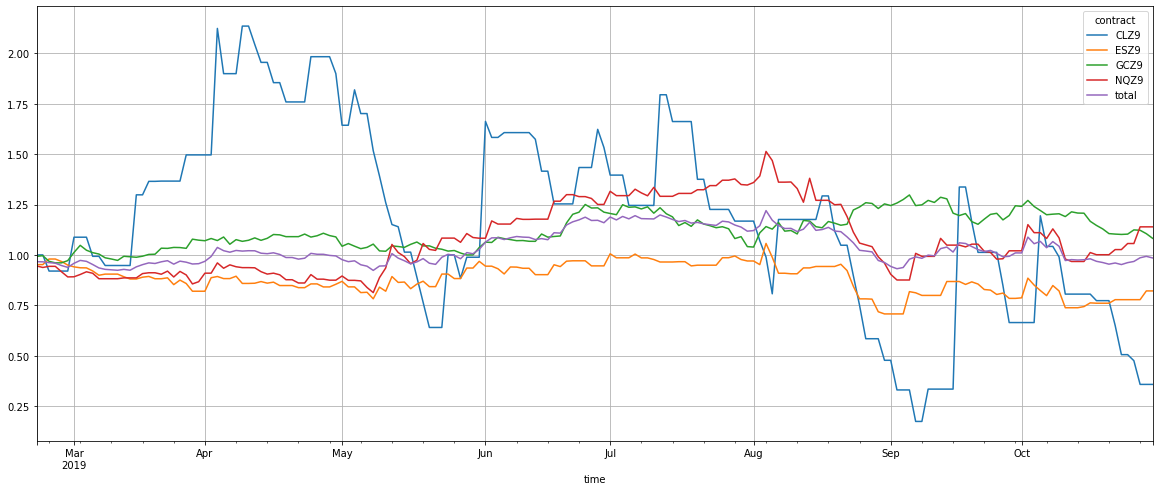

In [14]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [15]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CLZ9,ESZ9,GCZ9,NQZ9,total
Annual return,-0.762452,-0.240494,0.117373,0.200196,-0.020891
Cumulative returns,-0.641814,-0.178391,0.082498,0.139223,-0.014967
Annual volatility,4.301376,0.515155,0.321508,0.555538,0.302930
Sharpe ratio,0.764901,-0.282831,0.504122,0.597687,0.079672
Calmar ratio,-0.830367,-0.727448,0.695224,0.475310,-0.088443
Stability,0.296668,0.138927,0.564994,0.200284,0.087172
Max drawdown,-0.918210,-0.330600,-0.168827,-0.421189,-0.236207
Omega ratio,1.362485,0.939645,1.090050,1.131186,1.014010
Sortino ratio,2.654677,-0.453126,0.790642,1.042697,0.126024
Skew,7.917600,1.155819,0.471428,1.202982,0.724870
